In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
from sklearn.metrics import r2_score

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'
test_out_dir = '../../04_test/out/'

# data, primarily for the ice flags
soft_test_data_fpath = process_out_dir + 'soft_test_data.npz'
test_data_fpath = process_out_dir + 'test_data.npz'

# associated predictions
soft_test_preds_fpath = test_out_dir + 'massive_lstm_soft_test_preds_1_.npy'
test_preds_fpath = test_out_dir + 'massive_lstm_test_preds_1_.npy'

### Values

In [3]:
# when deriving the max ice on date, one detail is that
# we must omit the late ice on dates that occur during a
# (predicted) rethaw. This value is a temporal index
# representing the maximum day after July 1 that can
# be a considered a max ice on date.
# A value of 215 equates to February 1
ice_on_cutoff = 215

# Use to contruct 1-day bins on the histogram from (-num, num)
n_days_hist_cutoff = 75

# Looking at soft test in 3 ways:
#  train lake + test years
#  test lakes + train years
#  test lakes and years
n_compare = 3

# color guide
colors = ['#1b9e77', '#d95f02', '#7570b3']

### Outputs

In [4]:
test_set_eval_metrics_fpath = '../out/massive_lstm_test_metrics_1_.npz'

# Import data

In [5]:
# Import both testing partitions
soft_test_data = np.load(soft_test_data_fpath, allow_pickle = True)
test_data = np.load(test_data_fpath, allow_pickle = True)

# Extract everything from soft testing partition
soft_test_x = soft_test_data['x']
soft_test_y = soft_test_data['y']
soft_test_dates = soft_test_data['dates']
soft_test_DOW = soft_test_data['DOW']
soft_test_variables = soft_test_data['features']

# Extract everything from testing partition
test_x = test_data['x']
test_y = test_data['y']
test_dates = test_data['dates']
test_DOW = test_data['DOW']
test_variables = test_data['features']

# Import associated predictions
soft_test_preds = np.load(soft_test_preds_fpath)
test_preds = np.load(test_preds_fpath)

In [6]:
# Separate the two types of soft testing data
train_years_test_lakes_ids = np.argwhere(soft_test_data['dates'][:, 0] < test_data['dates'].min()).flatten()
test_years_train_lakes_ids = np.argwhere(soft_test_data['dates'][:, 0] >= test_data['dates'].min()).flatten()

train_years_test_lakes_preds = soft_test_preds[train_years_test_lakes_ids]
train_years_test_lakes_x = soft_test_x[train_years_test_lakes_ids]
train_years_test_lakes_y = soft_test_y[train_years_test_lakes_ids]
train_years_test_lakes_dates = soft_test_dates[train_years_test_lakes_ids]

test_years_train_lakes_preds = soft_test_preds[test_years_train_lakes_ids]
test_years_train_lakes_x = soft_test_x[test_years_train_lakes_ids]
test_years_train_lakes_y = soft_test_y[test_years_train_lakes_ids]
test_years_train_lakes_dates = soft_test_dates[test_years_train_lakes_ids]

In [7]:
assert (soft_test_x.shape[0] == (train_years_test_lakes_ids.shape[0] + 
                                 test_years_train_lakes_ids.shape[0]))

In [8]:
# Programmatically identify process-based ice flag data
ice_var_idx = int(np.argwhere(soft_test_variables == 'ice'))
assert test_variables[ice_var_idx] == 'ice'

# Start a pandas dataframe to store relevant information in

In [9]:
name_ls = ['train years, test lakes',
           'test years, train lakes',
           'test years and lakes']
min_pred_prob = [train_years_test_lakes_preds.min(),
                 test_years_train_lakes_preds.min(),
                 test_preds.min()]
max_pred_prob = [train_years_test_lakes_preds.max(),
                 test_years_train_lakes_preds.max(),
                 test_preds.max()]
    
eval_df = pd.DataFrame({'name':name_ls, 'min_pred_prob':min_pred_prob, 'max_pred_prob':max_pred_prob})
eval_df

,name,min_pred_prob,max_pred_prob
0,"train years, test lakes",0.000010,0.999807
1,"test years, train lakes",0.000009,0.999806
2,test years and lakes,0.000009,0.999818


# Convert predicted probabilities into predicted class (ice or not)

In [10]:
train_years_test_lakes_pred_class = np.round(train_years_test_lakes_preds)
test_years_train_lakes_pred_class = np.round(test_years_train_lakes_preds)
test_pred_class = np.round(test_preds)

# Overall accuracy

Including quick check on overfitting

In [11]:
def calc_accuracy(pred_probs, obs):
    # Here, the 0-index is just getting rid of the feature
    # dimension of the (originally) pytorch prediction object
    flat_preds = pred_probs[:, :, 0].flatten()
    flat_obs = obs.flatten()
    
    return np.sum(flat_preds == flat_obs) / flat_obs.shape[0]

def calc_accuracy_iceflags(inputs, obs):
    
    flat_ice_flags = inputs[:, :, ice_var_idx].flatten()
    flat_obs = obs.flatten()
    
    return np.sum(flat_ice_flags == flat_obs) / flat_obs.shape[0]

In [12]:
train_years_test_lakes_pred_class.shape

(681, 365, 1)

In [13]:
accuracy_ls = [calc_accuracy(train_years_test_lakes_pred_class, train_years_test_lakes_y),
               calc_accuracy(test_years_train_lakes_pred_class, test_years_train_lakes_y),
               calc_accuracy(test_pred_class, test_y)]

# store accuracy
eval_df['accuracy'] = accuracy_ls

# Error of predicted ice on/off dates

### Derive predicted max ice on and max ice off dates

In [14]:
def extract_date_i_and_date(ice_indications, dates):
    
    # ice_on_cutoff is globally defined
    
    ice_on_ids = []
    ice_off_ids = []
    
    ice_on = []
    ice_off = []

    for i in range(ice_indications.shape[0]):
        # Result in +1 when ice emerges and -1 when ice disappears. 0 otherwise.
        diff_i = np.diff(ice_indications[i, :])

        # Indexing by -1 finds the latest/"max" occurrence
        # for ice_on, we need to avoid late season refreeze ice on dates
        ice_on_index = np.argwhere(diff_i == 1)[np.argwhere(diff_i == 1) < ice_on_cutoff][-1].item()
        ice_off_index = np.argwhere(diff_i == -1)[-1].item()

        # Store found indices
        ice_on_ids.append(ice_on_index)
        ice_off_ids.append(ice_off_index)
        
        # Store found dates
        ice_on.append(dates[i, ice_on_index])
        ice_off.append(dates[i, ice_off_index])
        
    return(ice_on_ids, ice_off_ids,
           ice_on, ice_off)

In [15]:
# important dates = last ice on and last ice off
# get important dates and date-indices for observations
objects = extract_date_i_and_date(train_years_test_lakes_y, train_years_test_lakes_dates)
TrYTL_obs_ice_on_ids, TrYTL_obs_ice_off_ids, TrYTL_obs_ice_on, TrYTL_obs_ice_off = objects

# get important dates and date-indices for process-based ice flag
objects = extract_date_i_and_date(train_years_test_lakes_x[:, :, ice_var_idx], train_years_test_lakes_dates)
TrYTL_flag_ice_on_ids, TrYTL_flag_ice_off_ids, TrYTL_flag_ice_on, TrYTL_flag_ice_off = objects

# get important dates and date-indices for predictions
objects = extract_date_i_and_date(train_years_test_lakes_pred_class[:, :, 0], train_years_test_lakes_dates)
TrYTL_pred_ice_on_ids, TrYTL_pred_ice_off_ids, TrYTL_pred_ice_on, TrYTL_pred_ice_off = objects

In [16]:
# important dates = last ice on and last ice off
# get important dates and date-indices for observations
objects = extract_date_i_and_date(test_years_train_lakes_y, test_years_train_lakes_dates)
TYTrL_obs_ice_on_ids, TYTrL_obs_ice_off_ids, TYTrL_obs_ice_on, TYTrL_obs_ice_off = objects

# get important dates and date-indices for process-based ice flag
objects = extract_date_i_and_date(test_years_train_lakes_x[:, :, ice_var_idx], test_years_train_lakes_dates)
TYTrL_flag_ice_on_ids, TYTrL_flag_ice_off_ids, TYTrL_flag_ice_on, TYTrL_flag_ice_off = objects

# get important dates and date-indices for predictions
objects = extract_date_i_and_date(test_years_train_lakes_pred_class[:, :, 0], test_years_train_lakes_dates)
TYTrL_pred_ice_on_ids, TYTrL_pred_ice_off_ids, TYTrL_pred_ice_on, TYTrL_pred_ice_off = objects

In [17]:
# important dates = last ice on and last ice off
# get important dates and date-indices for observations
objects = extract_date_i_and_date(test_y, test_dates)
test_obs_ice_on_ids, test_obs_ice_off_ids, test_obs_ice_on, test_obs_ice_off = objects

# get important dates and date-indices for process-based ice flag
objects = extract_date_i_and_date(test_x[:, :, ice_var_idx], test_dates)
test_flag_ice_on_ids, test_flag_ice_off_ids, test_flag_ice_on, test_flag_ice_off = objects

# get important dates and date-indices for predictions
objects = extract_date_i_and_date(test_pred_class[:, :, 0], test_dates)
test_pred_ice_on_ids, test_pred_ice_off_ids, test_pred_ice_on, test_pred_ice_off = objects

### Define some functions to deal with those dates

In [18]:
def calc_date_errors(pred_dates, obs_dates):
    # convert obj/str dates into datetimes
    formatted_obs_dates = np.asarray(obs_dates).astype(np.datetime64)
    formatted_pred_dates = np.asarray(pred_dates).astype(np.datetime64)
    
    # calc simple difference
    pred_errors = formatted_obs_dates - formatted_pred_dates
    
    # convert datetime difference to int (days)
    pred_errors = pred_errors.astype(int)
    
    return pred_errors

# simple RMSE calculation
def calc_rmse(errors):
    return np.sqrt(np.sum(errors**2) / len(errors))

### Errors for ice on

In [19]:
TrYTL_pred_ice_on_error = calc_date_errors(TrYTL_pred_ice_on, TrYTL_obs_ice_on)
TrYTL_flag_ice_on_error = calc_date_errors(TrYTL_flag_ice_on, TrYTL_obs_ice_on)

TYTrL_pred_ice_on_error = calc_date_errors(TYTrL_pred_ice_on, TYTrL_obs_ice_on)
TYTrL_flag_ice_on_error = calc_date_errors(TYTrL_flag_ice_on, TYTrL_obs_ice_on)

test_pred_ice_on_error = calc_date_errors(test_pred_ice_on, test_obs_ice_on)
test_flag_ice_on_error = calc_date_errors(test_flag_ice_on, test_obs_ice_on)

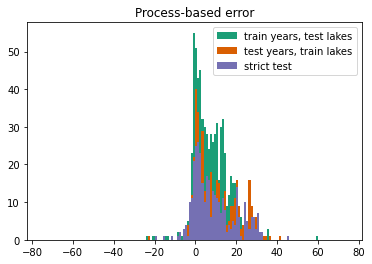

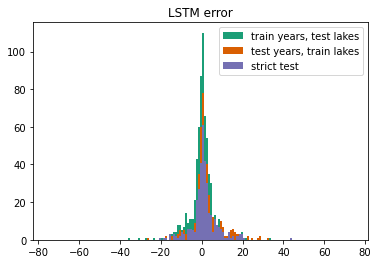

In [20]:
# view distribution of PB errors
plt.hist(TrYTL_flag_ice_on_error, label = 'train years, test lakes',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[0])
plt.hist(TYTrL_flag_ice_on_error, label = 'test years, train lakes',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[1])
plt.hist(test_flag_ice_on_error, label = 'strict test',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[2])
plt.title('Process-based error')
plt.legend()
plt.pause(0.001)

# view distribution of LSTM errors
plt.hist(TrYTL_pred_ice_on_error, label = 'train years, test lakes',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[0])
plt.hist(TYTrL_pred_ice_on_error, label = 'test years, train lakes',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[1])
plt.hist(test_pred_ice_on_error, label = 'strict test',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[2])
plt.title('LSTM error')
plt.legend()
plt.pause(0.001)

In [21]:
# calculate average of errors and RMSE
ice_on_avg_error = [np.mean(TrYTL_pred_ice_on_error),
                    np.mean(TYTrL_pred_ice_on_error),
                    np.mean(test_pred_ice_on_error)]
ice_on_rmse = [calc_rmse(TrYTL_pred_ice_on_error),
               calc_rmse(TYTrL_pred_ice_on_error),
               calc_rmse(test_pred_ice_on_error)]

# store in dataframe
eval_df['ice_on_avg_error'] = ice_on_avg_error
eval_df['ice_on_rmse'] = ice_on_rmse

### Errors for ice off

In [22]:
TrYTL_pred_ice_off_error = calc_date_errors(TrYTL_pred_ice_off, TrYTL_obs_ice_off)
TrYTL_flag_ice_off_error = calc_date_errors(TrYTL_flag_ice_off, TrYTL_obs_ice_off)

TYTrL_pred_ice_off_error = calc_date_errors(TYTrL_pred_ice_off, TYTrL_obs_ice_off)
TYTrL_flag_ice_off_error = calc_date_errors(TYTrL_flag_ice_off, TYTrL_obs_ice_off)

test_pred_ice_off_error = calc_date_errors(test_pred_ice_off, test_obs_ice_off)
test_flag_ice_off_error = calc_date_errors(test_flag_ice_off, test_obs_ice_off)

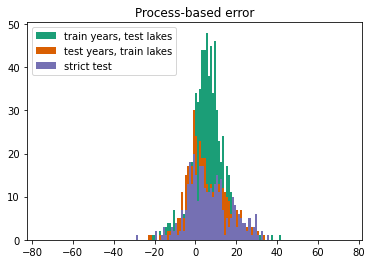

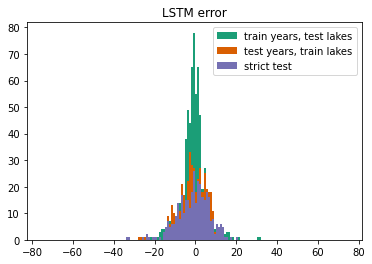

In [23]:
# view distribution of PB errors
plt.hist(TrYTL_flag_ice_off_error, label = 'train years, test lakes',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[0])
plt.hist(TYTrL_flag_ice_off_error, label = 'test years, train lakes',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[1])
plt.hist(test_flag_ice_off_error, label = 'strict test',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[2])
plt.title('Process-based error')
plt.legend()
plt.pause(0.001)

# view distribution of LSTM errors
plt.hist(TrYTL_pred_ice_off_error, label = 'train years, test lakes',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[0])
plt.hist(TYTrL_pred_ice_off_error, label = 'test years, train lakes',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[1])
plt.hist(test_pred_ice_off_error, label = 'strict test',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = colors[2])
plt.title('LSTM error')
plt.legend()
plt.pause(0.001)

In [24]:
# calculate average of errors and RMSE
ice_off_avg_error = [np.mean(TrYTL_pred_ice_off_error),
                     np.mean(TYTrL_pred_ice_off_error),
                     np.mean(test_pred_ice_on_error)
                   ]
ice_off_rmse = [calc_rmse(TrYTL_pred_ice_off_error),
                calc_rmse(TYTrL_pred_ice_off_error),
                calc_rmse(test_pred_ice_on_error)]

# store in dataframe
eval_df['ice_off_avg_error'] = ice_off_avg_error
eval_df['ice_off_rmse'] = ice_off_rmse

### Error for predicted ice duration

In [25]:
# Simply take number of days between ice on and ice off for ice duration
def calc_ice_duration(off, on):
    dur = np.asarray(off).astype(np.datetime64) - np.asarray(on).astype(np.datetime64)
    return dur.astype(int)

In [26]:
TrYTL_obs_dur = calc_ice_duration(TrYTL_obs_ice_off, TrYTL_obs_ice_on)
# flag
TrYTL_flag_dur = calc_ice_duration(TrYTL_flag_ice_off, TrYTL_flag_ice_on)
TrYTL_flag_dur_error = TrYTL_obs_dur - TrYTL_flag_dur
# lstm
TrYTL_pred_dur = calc_ice_duration(TrYTL_pred_ice_off, TrYTL_pred_ice_on)
TrYTL_pred_dur_error = TrYTL_obs_dur - TrYTL_pred_dur

In [27]:
TYTrL_obs_dur = calc_ice_duration(TYTrL_obs_ice_off, TYTrL_obs_ice_on)
# flag
TYTrL_flag_dur = calc_ice_duration(TYTrL_flag_ice_off, TYTrL_flag_ice_on)
TYTrL_flag_dur_error = TYTrL_obs_dur - TYTrL_flag_dur
# lstm
TYTrL_pred_dur = calc_ice_duration(TYTrL_pred_ice_off, TYTrL_pred_ice_on)
TYTrL_pred_dur_error = TYTrL_obs_dur - TYTrL_pred_dur

In [28]:
test_obs_dur = calc_ice_duration(test_obs_ice_off, test_obs_ice_on)
# flag
test_flag_dur = calc_ice_duration(test_flag_ice_off, test_flag_ice_on)
test_flag_dur_error = test_obs_dur - test_flag_dur
# lstm
test_pred_dur = calc_ice_duration(test_pred_ice_off, test_pred_ice_on)
test_pred_dur_error = test_obs_dur - test_pred_dur

In [29]:
ice_dur_avg_error = [np.mean(TrYTL_pred_dur_error),
                     np.mean(TYTrL_pred_dur_error),
                     np.mean(test_pred_dur_error),]

ice_dur_rmse = [calc_rmse(TrYTL_pred_dur_error),
                calc_rmse(TYTrL_pred_dur_error),
                calc_rmse(test_pred_dur_error)]

eval_df['ice_dur_avg_error'] = ice_dur_avg_error
eval_df['ice_dur_rmse'] = ice_dur_rmse

# Add process-based ice flag evaluation to the dataframe

In [30]:
PB_TrYTL_row = ['PB train years, test lakes', 0, 1,
                calc_accuracy(train_years_test_lakes_x[:, :, [ice_var_idx]],
                              train_years_test_lakes_y),
                np.mean(TrYTL_flag_ice_on_error),
                calc_rmse(TrYTL_flag_ice_on_error),
                np.mean(TrYTL_flag_ice_off_error),
                calc_rmse(TrYTL_flag_ice_off_error),
                np.mean(TrYTL_flag_dur_error),
                calc_rmse(TrYTL_flag_dur_error)]

PB_TYTrL_row = ['PB test years, train lakes', 0, 1,
                calc_accuracy(test_years_train_lakes_x[:, :, [ice_var_idx]],
                              test_years_train_lakes_y),
                np.mean(TYTrL_flag_ice_on_error),
                calc_rmse(TYTrL_flag_ice_on_error),
                np.mean(TYTrL_flag_ice_off_error),
                calc_rmse(TYTrL_flag_ice_off_error),
                np.mean(TYTrL_flag_dur_error),
                calc_rmse(TYTrL_flag_dur_error)]

PB_test_row = ['PB test years and lakes', 0, 1,
               calc_accuracy(test_x[:, :, [ice_var_idx]], test_y),
               np.mean(test_flag_ice_on_error),
               calc_rmse(test_flag_ice_on_error),
               np.mean(test_flag_ice_off_error),
               calc_rmse(test_flag_ice_off_error),
               np.mean(test_flag_dur_error),
               calc_rmse(test_flag_dur_error)]

eval_df.loc[len(eval_df)] = PB_TrYTL_row
eval_df.loc[len(eval_df)] = PB_TYTrL_row
eval_df.loc[len(eval_df)] = PB_test_row

In [31]:
eval_df

,name,min_pred_prob,max_pred_prob,accuracy,ice_on_avg_error,ice_on_rmse,ice_off_avg_error,ice_off_rmse,ice_dur_avg_error,ice_dur_rmse
0,"train years, test lakes",0.000010,0.999807,0.977531,-0.209985,6.333488,-1.199706,6.281572,-0.989721,9.156335
1,"test years, train lakes",0.000009,0.999806,0.972763,1.528037,6.953450,-1.443925,6.944708,-2.971963,9.770258
2,test years and lakes,0.000009,0.999818,0.972070,0.751429,6.341023,0.751429,6.341023,-2.271429,10.317115
3,"PB train years, test lakes",0.000000,1.000000,0.957428,7.146843,10.886479,5.585903,9.408810,-1.560940,11.824525
4,"PB test years, train lakes",0.000000,1.000000,0.949033,9.523364,13.809620,5.336449,11.034991,-4.186916,13.181515
5,PB test years and lakes,0.000000,1.000000,0.948423,8.408571,13.157182,6.208571,12.199415,-2.200000,13.700052


# Compare PB to LSTM in each partition

In [32]:
rmse_df = eval_df.loc[:, ['ice_on_rmse', 'ice_off_rmse', 'ice_dur_rmse']]
rmse_df

,ice_on_rmse,ice_off_rmse,ice_dur_rmse
0,6.333488,6.281572,9.156335
1,6.953450,6.944708,9.770258
2,6.341023,6.341023,10.317115
3,10.886479,9.408810,11.824525
4,13.809620,11.034991,13.181515
5,13.157182,12.199415,13.700052


In [33]:
perc_change_ls = []

for i in range(n_compare):
    
    lstm_perf = rmse_df.iloc[i]
    pb_perf = rmse_df.iloc[i + n_compare]
    
    perc_change = (lstm_perf - pb_perf) / pb_perf
    
    perc_change_ls.append(np.mean(perc_change))


 [-0.3254154943125983, -0.37531119452178946, -0.4150680050098518] 



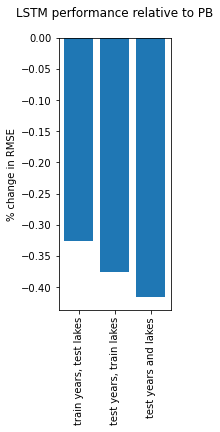

In [34]:
plt.figure(figsize = (2,5))
plt.bar(range(n_compare), perc_change_ls)
plt.xticks(range(n_compare), eval_df['name'][:n_compare], rotation = 90)
plt.title('LSTM performance relative to PB\n')
plt.ylabel('% change in RMSE')

print('\n', perc_change_ls, '\n')

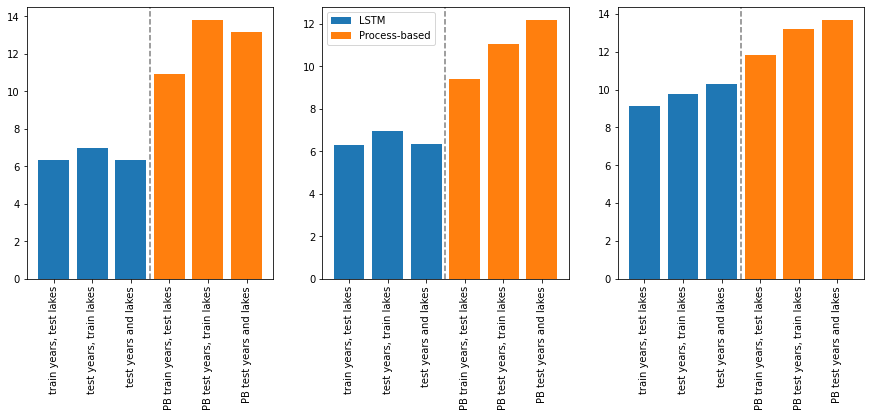

In [35]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

lstm_df = eval_df.iloc[:n_compare]
pb_df = eval_df.iloc[n_compare:]

ax[0].bar(lstm_df['name'], lstm_df['ice_on_rmse'])
ax[0].bar(pb_df['name'], pb_df['ice_on_rmse'])
ax[0].set_xticks(range(eval_df.shape[0]), eval_df['name'], rotation = 90)
ax[0].axvline(n_compare - 0.5, color = 'gray', linestyle = '--')

ax[1].bar(lstm_df['name'], lstm_df['ice_off_rmse'], label = 'LSTM')
ax[1].bar(pb_df['name'], pb_df['ice_off_rmse'], label = 'Process-based')
ax[1].set_xticks(range(eval_df.shape[0]), eval_df['name'], rotation = 90)
ax[1].axvline(n_compare - 0.5, color = 'gray', linestyle = '--')
ax[1].legend()

ax[2].bar(lstm_df['name'], lstm_df['ice_dur_rmse'])
ax[2].bar(pb_df['name'], pb_df['ice_dur_rmse'])
ax[2].set_xticks(range(eval_df.shape[0]), eval_df['name'], rotation = 90)
ax[2].axvline(n_compare - 0.5, color = 'gray', linestyle = '--')

# Save these calculcated errors

In [36]:
# Batch all these calculated errors together
evals = {'TrYTL_flag_error_ice_on':TrYTL_flag_ice_on_error,
         'TrYTL_flag_error_ice_off':TrYTL_flag_ice_off_error,
         'TrYTL_flag_error_dur':TrYTL_flag_dur_error,
         'TYTrL_flag_error_ice_on':TYTrL_flag_ice_on_error,
         'TYTrL_flag_error_ice_off':TYTrL_flag_ice_off_error,
         'TYTrL_flag_error_dur':TYTrL_flag_dur_error,
         'test_flag_error_ice_on':test_flag_ice_on_error,
         'test_flag_error_ice_off':test_flag_ice_off_error,
         'test_flag_error_dur':test_flag_dur_error,
         'TrYTL_pred_error_ice_on':TrYTL_pred_ice_on_error,
         'TrYTL_pred_error_ice_off':TrYTL_pred_ice_off_error,
         'TrYTL_pred_error_dur':TrYTL_pred_dur_error,
         'TYTrL_pred_error_ice_on':TYTrL_pred_ice_on_error,
         'TYTrL_pred_error_ice_off':TYTrL_pred_ice_off_error,
         'TYTrL_pred_error_dur':TYTrL_pred_dur_error,
         'test_pred_error_ice_on':test_pred_ice_on_error,
         'test_pred_error_ice_off':test_pred_ice_off_error,
         'test_pred_error_dur':test_pred_dur_error}

In [37]:
np.savez_compressed(test_set_eval_metrics_fpath, **evals)

<br><br><br><br><br>

# Additional recommended plots

I'm doing these in the evaluation metrics notebook instead of the plotting notebook because they are related to higher level prediction targets considered here, rather than evaluating residuals, which is the primary focus of the other notebook.

### Scatter plots of observations versus predictions


			R-squared values

				   PB		LSTM
Train Years, Test Lakes		 0.114  	 0.7
Test Years, Train Lakes		 -0.168  	 0.704
Test Years and Lakes		 -0.138  	 0.736 



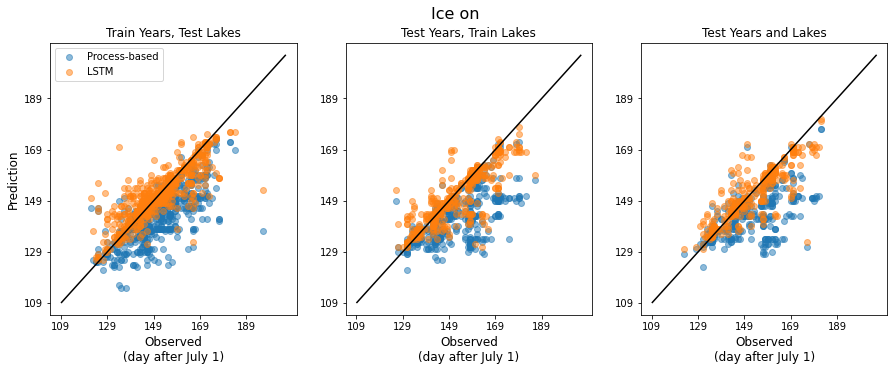

In [38]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

# Determine a shared lower and upper lim for 1:1 plot
lower_lim = min([min(TrYTL_obs_ice_on_ids), min(TYTrL_obs_ice_on_ids), min(test_obs_ice_on_ids),
                 min(TrYTL_flag_ice_on_ids), min(TYTrL_flag_ice_on_ids), min(test_flag_ice_on_ids),
                 min(TrYTL_pred_ice_on_ids), min(TYTrL_pred_ice_on_ids), min(test_pred_ice_on_ids)])
upper_lim = max([max(TrYTL_obs_ice_on_ids), max(TYTrL_obs_ice_on_ids), max(test_obs_ice_on_ids),
                 max(TrYTL_flag_ice_on_ids), max(TYTrL_flag_ice_on_ids), max(test_flag_ice_on_ids),
                 max(TrYTL_pred_ice_on_ids), max(TYTrL_pred_ice_on_ids), max(test_pred_ice_on_ids)])
lower_lim = lower_lim - lower_lim*0.05
upper_lim = upper_lim + upper_lim*0.05

# Calculate corr
# ... PB
TrYTL_cor_flag = np.round(r2_score(TrYTL_obs_ice_on_ids, TrYTL_flag_ice_on_ids), 3)
TYTrL_cor_flag = np.round(r2_score(TYTrL_obs_ice_on_ids, TYTrL_flag_ice_on_ids), 3)
test_cor_flag = np.round(r2_score(test_obs_ice_on_ids, test_flag_ice_on_ids), 3)
# ... LSTM
TrYTL_cor_pred = np.round(r2_score(TrYTL_obs_ice_on_ids, TrYTL_pred_ice_on_ids), 3)
TYTrL_cor_pred = np.round(r2_score(TYTrL_obs_ice_on_ids, TYTrL_pred_ice_on_ids), 3)
test_cor_pred = np.round(r2_score(test_obs_ice_on_ids, test_pred_ice_on_ids), 3)

# Actual plotting
# ... PB
ax[0].scatter(TrYTL_obs_ice_on_ids, TrYTL_flag_ice_on_ids, alpha = 0.5, label = 'Process-based')
ax[1].scatter(TYTrL_obs_ice_on_ids, TYTrL_flag_ice_on_ids, alpha = 0.5)
ax[2].scatter(test_obs_ice_on_ids, test_flag_ice_on_ids, alpha = 0.5)
# ... LTSMs
ax[0].scatter(TrYTL_obs_ice_on_ids, TrYTL_pred_ice_on_ids, alpha = 0.5, label = 'LSTM')
ax[1].scatter(TYTrL_obs_ice_on_ids, TYTrL_pred_ice_on_ids, alpha = 0.5)
ax[2].scatter(test_obs_ice_on_ids, test_pred_ice_on_ids, alpha = 0.5)

# All the labels
fig.suptitle('Ice on', fontsize = 16)
ax[0].set_title('Train Years, Test Lakes')
ax[1].set_title('Test Years, Train Lakes')
ax[2].set_title('Test Years and Lakes')

# some formating for all plots
for i in range(3):
    ax[i].plot([lower_lim, upper_lim], [lower_lim, upper_lim], color = 'black')
    ax[i].set_xticks(np.arange(int(lower_lim), int(upper_lim), 20))
    ax[i].set_yticks(np.arange(int(lower_lim), int(upper_lim), 20))
    ax[i].set_xlabel('Observed\n(day after July 1)', fontsize = 12)
            
ax[0].set_ylabel('Prediction', fontsize = 12)
ax[0].legend();

print('\n\t\t\tR-squared values\n')
print('\t\t\t\t   PB\t\tLSTM')
print('Train Years, Test Lakes\t\t', TrYTL_cor_flag, ' \t', TrYTL_cor_pred)
print('Test Years, Train Lakes\t\t', TYTrL_cor_flag, ' \t', TYTrL_cor_pred)
print('Test Years and Lakes\t\t', test_cor_flag, ' \t', test_cor_pred, '\n')


			R-squared values

				   PB		LSTM
Train Years, Test Lakes		 0.33   	 0.701
Test Years, Train Lakes		 0.594  	 0.839
Test Years and Lakes		 0.551  	 0.805 



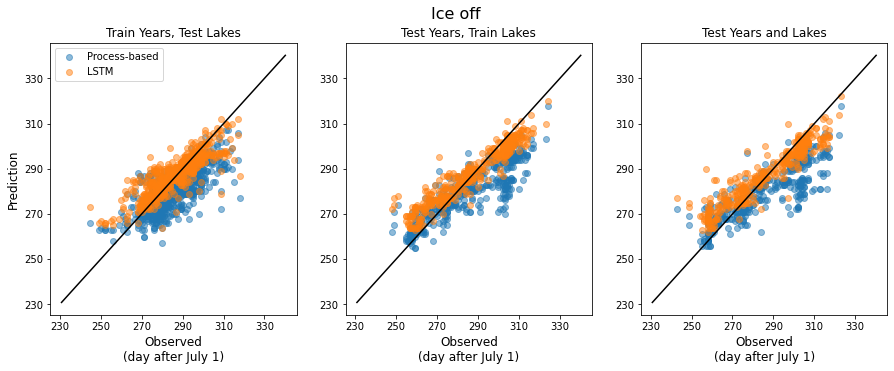

In [39]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

# Determine a shared lower and upper lim for 1:1 plot
lower_lim = min([min(TrYTL_obs_ice_off_ids), min(TYTrL_obs_ice_off_ids), min(test_obs_ice_off_ids),
                 min(TrYTL_flag_ice_off_ids), min(TYTrL_flag_ice_off_ids), min(test_flag_ice_off_ids),
                 min(TrYTL_pred_ice_off_ids), min(TYTrL_pred_ice_off_ids), min(test_pred_ice_off_ids)])
upper_lim = max([max(TrYTL_obs_ice_off_ids), max(TYTrL_obs_ice_off_ids), max(test_obs_ice_off_ids),
                 max(TrYTL_flag_ice_off_ids), max(TYTrL_flag_ice_off_ids), max(test_flag_ice_off_ids),
                 max(TrYTL_pred_ice_off_ids), max(TYTrL_pred_ice_off_ids), max(test_pred_ice_off_ids)])
lower_lim = lower_lim - lower_lim*0.05
upper_lim = upper_lim + upper_lim*0.05

# Calculate corr
# ... PB
TrYTL_cor_flag = np.round(r2_score(TrYTL_obs_ice_off_ids, TrYTL_flag_ice_off_ids), 3)
TYTrL_cor_flag = np.round(r2_score(TYTrL_obs_ice_off_ids, TYTrL_flag_ice_off_ids), 3)
test_cor_flag = np.round(r2_score(test_obs_ice_off_ids, test_flag_ice_off_ids), 3)
# ... LSTM
TrYTL_cor_pred = np.round(r2_score(TrYTL_obs_ice_off_ids, TrYTL_pred_ice_off_ids), 3)
TYTrL_cor_pred = np.round(r2_score(TYTrL_obs_ice_off_ids, TYTrL_pred_ice_off_ids), 3)
test_cor_pred = np.round(r2_score(test_obs_ice_off_ids, test_pred_ice_off_ids), 3)

# Actual plotting
# ... PB
ax[0].scatter(TrYTL_obs_ice_off_ids, TrYTL_flag_ice_off_ids, alpha = 0.5, label = 'Process-based')
ax[1].scatter(TYTrL_obs_ice_off_ids, TYTrL_flag_ice_off_ids, alpha = 0.5)
ax[2].scatter(test_obs_ice_off_ids, test_flag_ice_off_ids, alpha = 0.5)
# ... LTSMs
ax[0].scatter(TrYTL_obs_ice_off_ids, TrYTL_pred_ice_off_ids, alpha = 0.5, label = 'LSTM')
ax[1].scatter(TYTrL_obs_ice_off_ids, TYTrL_pred_ice_off_ids, alpha = 0.5)
ax[2].scatter(test_obs_ice_off_ids, test_pred_ice_off_ids, alpha = 0.5)

# All the labels
fig.suptitle('Ice off', fontsize = 16)
ax[0].set_title('Train Years, Test Lakes')
ax[1].set_title('Test Years, Train Lakes')
ax[2].set_title('Test Years and Lakes')

# some formating for all plots
for i in range(3):
    ax[i].plot([lower_lim, upper_lim], [lower_lim, upper_lim], color = 'black')
    ax[i].set_xticks(np.arange(int(lower_lim), int(upper_lim), 20))
    ax[i].set_yticks(np.arange(int(lower_lim), int(upper_lim), 20))
    ax[i].set_xlabel('Observed\n(day after July 1)', fontsize = 12)
            
ax[0].set_ylabel('Prediction', fontsize = 12)
ax[0].legend();

print('\n\t\t\tR-squared values\n')
print('\t\t\t\t   PB\t\tLSTM')
print('Train Years, Test Lakes\t\t', TrYTL_cor_flag, '  \t', TrYTL_cor_pred)
print('Test Years, Train Lakes\t\t', TYTrL_cor_flag, ' \t', TYTrL_cor_pred)
print('Test Years and Lakes\t\t', test_cor_flag, ' \t', test_cor_pred, '\n')


			R-squared values

				   PB		LSTM
Train Years, Test Lakes		 0.582  	 0.749
Test Years, Train Lakes		 0.694  	 0.832
Test Years and Lakes		 0.683  	 0.82 



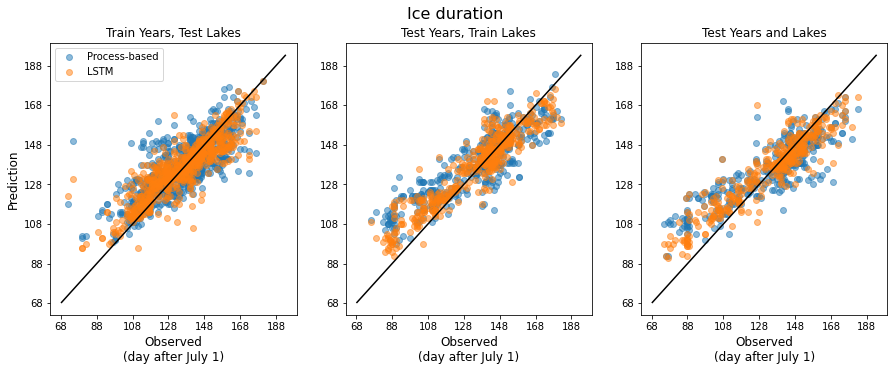

In [40]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

# Determine a shared lower and upper lim for 1:1 plot
lower_lim = min([min(TrYTL_obs_dur), min(TYTrL_obs_dur), min(test_obs_dur),
                 min(TrYTL_flag_dur), min(TYTrL_flag_dur), min(test_flag_dur),
                 min(TrYTL_pred_dur), min(TYTrL_pred_dur), min(test_pred_dur)])
upper_lim = max([max(TrYTL_obs_dur), max(TYTrL_obs_dur), max(test_obs_dur),
                 max(TrYTL_flag_dur), max(TYTrL_flag_dur), max(test_flag_dur),
                 max(TrYTL_pred_dur), max(TYTrL_pred_dur), max(test_pred_dur)])
lower_lim = lower_lim - lower_lim*0.05
upper_lim = upper_lim + upper_lim*0.05

# Calculate corr
# ... PB
TrYTL_cor_flag = np.round(r2_score(TrYTL_obs_dur, TrYTL_flag_dur), 3)
TYTrL_cor_flag = np.round(r2_score(TYTrL_obs_dur, TYTrL_flag_dur), 3)
test_cor_flag = np.round(r2_score(test_obs_dur, test_flag_dur), 3)
# ... LSTM
TrYTL_cor_pred = np.round(r2_score(TrYTL_obs_dur, TrYTL_pred_dur), 3)
TYTrL_cor_pred = np.round(r2_score(TYTrL_obs_dur, TYTrL_pred_dur), 3)
test_cor_pred = np.round(r2_score(test_obs_dur, test_pred_dur), 3)

# Actual plotting
# ... PB
ax[0].scatter(TrYTL_obs_dur, TrYTL_flag_dur, alpha = 0.5, label = 'Process-based')
ax[1].scatter(TYTrL_obs_dur, TYTrL_flag_dur, alpha = 0.5)
ax[2].scatter(test_obs_dur, test_flag_dur, alpha = 0.5)
# ... LTSMs
ax[0].scatter(TrYTL_obs_dur, TrYTL_pred_dur, alpha = 0.5, label = 'LSTM')
ax[1].scatter(TYTrL_obs_dur, TYTrL_pred_dur, alpha = 0.5)
ax[2].scatter(test_obs_dur, test_pred_dur, alpha = 0.5)

# All the labels
fig.suptitle('Ice duration', fontsize = 16)
ax[0].set_title('Train Years, Test Lakes')
ax[1].set_title('Test Years, Train Lakes')
ax[2].set_title('Test Years and Lakes')

# some formating for all plots
for i in range(3):
    ax[i].plot([lower_lim, upper_lim], [lower_lim, upper_lim], color = 'black')
    ax[i].set_xticks(np.arange(int(lower_lim), int(upper_lim), 20))
    ax[i].set_yticks(np.arange(int(lower_lim), int(upper_lim), 20))
    ax[i].set_xlabel('Observed\n(day after July 1)', fontsize = 12)
            
ax[0].set_ylabel('Prediction', fontsize = 12)
ax[0].legend();

print('\n\t\t\tR-squared values\n')
print('\t\t\t\t   PB\t\tLSTM')
print('Train Years, Test Lakes\t\t', TrYTL_cor_flag, ' \t', TrYTL_cor_pred)
print('Test Years, Train Lakes\t\t', TYTrL_cor_flag, ' \t', TYTrL_cor_pred)
print('Test Years and Lakes\t\t', test_cor_flag, ' \t', test_cor_pred, '\n')